In [1]:
import numpy as np
import pandas as pd
from scipy import stats
from scipy.stats import chi2_contingency, chi2, mannwhitneyu, shapiro, kruskal
import matplotlib.pyplot as plt

from tqdm.auto import tqdm

In [2]:
df = pd.read_csv('https://stepik.org/media/attachments/lesson/396012/hw_aa.csv', sep=';', index_col=0)
df.head()

,uid,experimentVariant,version,purchase
1,c4ca4238a0b923820dcc509a6f75849b,1,v2.8.0,0
2,c81e728d9d4c2f636f067f89cc14862c,0,v2.9.0,0
3,eccbc87e4b5ce2fe28308fd9f2a7baf3,1,v2.9.0,0
4,a87ff679a2f3e71d9181a67b7542122c,1,v2.8.0,0
5,e4da3b7fbbce2345d7772b0674a318d5,1,v2.8.0,0


In [3]:
df.dtypes

uid                  object
experimentVariant     int64
version              object
purchase              int64
dtype: object

---

<font size=6>1.Проверка системы сплитования на группы A1 и A2</font>

In [4]:
#Формируем выборки A1 и A2, в которых оставляем только колонку purchase, по которой будем считать конверсию
a_1 = df.query('experimentVariant == 0').purchase
a_2 = df.query('experimentVariant == 1').purchase

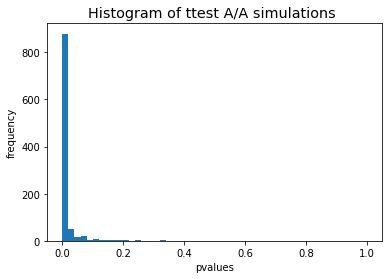

0.938

In [5]:
n = 100000
simulations = 1000
n_s = 1000
res = []

# Запуск симуляций A/A теста
for i in tqdm(range(simulations)):
    s1 = a_1.sample(n_s, replace = False)
    s2 = a_2.sample(n_s, replace = False)
    res.append(stats.ttest_ind(s1, s2, equal_var = False)[1]) 

plt.hist(res, bins = 50)
plt.style.use('ggplot')
plt.xlabel('pvalues')
plt.ylabel('frequency')
plt.title("Histogram of ttest A/A simulations ")
plt.show()

# Проверяем, что количество ложноположительных случаев не превышает альфа
sum(np.array(res) <0.05) / simulations

### В более чем 90% случаев мы получаем статистически значимые различия, что сигнализирует о том, что система сплитования работает неверно.

---

<font size=6>2.Поиск среза данных, в которых наблюдается аномалия</font>

In [6]:
#Посчитаем конверсию в группах с помощью mean и размер групп 
df.groupby(['version', 'experimentVariant']) \
    .agg({'purchase': 'mean', 'uid' : 'count'})

purchase    uid
version  experimentVariant                 
v2.8.0   0                  0.000993  41283
         1                  0.045606  41552
v2.9.0   0                  0.074658  11921
         1                  0.071304  12033
v3.7.4.0 0                  0.059943   4204
         1                  0.063018   4221
v3.8.0.0 0                  0.057604   5694
         1                  0.062848   6110

### Сразу бросается в глаза конверсия в группе с версией МП v2.8.0.

---

<font size=6>3.Повтор А-А теста без учета версии 2.8.0.</font>

In [7]:
a_1_upd = df.query('experimentVariant == 0 & version != "v2.8.0"').purchase
a_2_upd = df.query('experimentVariant == 1 & version != "v2.8.0"').purchase

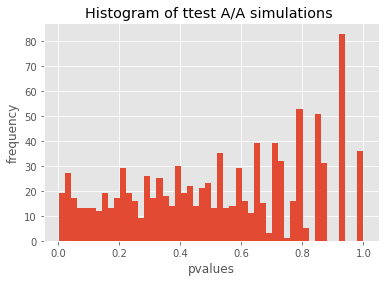

0.053

In [8]:
n = 100000
simulations = 1000
n_s = 1000
res = []

# Запуск симуляций A/A теста
for i in tqdm(range(simulations)):
    s1 = a_1_upd.sample(n_s, replace = False)
    s2 = a_2_upd.sample(n_s, replace = False)
    res.append(stats.ttest_ind(s1, s2, equal_var = False)[1]) 

plt.hist(res, bins = 50)
plt.style.use('ggplot')
plt.xlabel('pvalues')
plt.ylabel('frequency')
plt.title("Histogram of ttest A/A simulations ")
plt.show()

# Проверяем, что количество ложноположительных случаев не превышает альфа
sum(np.array(res) <0.05) / simulations

## Проблема обнаружена: все дело в версии МП 2.8.0, из-за нее наблюдается перекос конверсии в группах А1 и А2.